<a href="https://colab.research.google.com/github/JamesMcGuigan/dlaicourse/blob/master/Exercises/Exercise%205%20-%20Real%20World%20Scenarios/Exercise%205%20-%20Question.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# In this exercise you will train a CNN on the FULL Cats-v-dogs dataset
# This will require you doing a lot of data preprocessing because
# the dataset isn't split into training and validation for you
# This code block has all the required inputs
import os
import zipfile
import random
import tensorflow as tf
import numpy as np
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

In [72]:
# This code block downloads the full Cats-v-Dogs dataset and stores it as 
# cats-and-dogs.zip. It then unzips it to /tmp
# which will create a tmp/PetImages directory containing subdirectories
# called 'Cat' and 'Dog' (that's how the original researchers structured it)
# If the URL doesn't work, 
# .   visit https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765
# And right click on the 'Download Manually' link to get a new URL

!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()


--2020-03-06 15:43:24--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.36.252.127, 2600:1417:3f:8a0::e59, 2600:1417:3f:898::e59
Connecting to download.microsoft.com (download.microsoft.com)|23.36.252.127|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.68M  9.17MB/s    in 89s     

2020-03-06 15:44:53 (8.87 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824894548/824894548]



In [73]:
print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))

# Expected Output:
# 12501
# 12501

12501
12501


In [0]:
!rm -rf /tmp/cats-v-dogs/

In [75]:
# Use os.mkdir to create your directories
# You will need a directory for cats-v-dogs, and subdirectories for training
# and testing. These in turn will need subdirectories for 'cats' and 'dogs'
try:
    os.mkdir('/tmp/cats-v-dogs')
    for test_train in ['testing', 'training']:
      os.mkdir(f'/tmp/cats-v-dogs/{test_train}/')      
      print(f'/tmp/cats-v-dogs/{test_train}/')
      for cat_dog in ['cats', 'dogs']:      
        os.mkdir(f'/tmp/cats-v-dogs/{test_train}/{cat_dog}')              
        print(f'/tmp/cats-v-dogs/{test_train}/{cat_dog}')                      
except OSError:
    pass

/tmp/cats-v-dogs/testing/
/tmp/cats-v-dogs/testing/cats
/tmp/cats-v-dogs/testing/dogs
/tmp/cats-v-dogs/training/
/tmp/cats-v-dogs/training/cats
/tmp/cats-v-dogs/training/dogs


In [76]:
# Write a python function called split_data which takes
# a SOURCE directory containing the files
# a TRAINING directory that a portion of the files will be copied to
# a TESTING directory that a portion of the files will be copie to
# a SPLIT SIZE to determine the portion
# The files should also be randomized, so that the training set is a random
# X% of the files, and the test set is the remaining files
# SO, for example, if SOURCE is PetImages/Cat, and SPLIT SIZE is .9
# Then 90% of the images in PetImages/Cat will be copied to the TRAINING dir
# and 10% of the images will be copied to the TESTING dir
# Also -- All images should be checked, and if they have a zero file length,
# they will not be copied over
#
# os.listdir(DIRECTORY) gives you a listing of the contents of that directory
# os.path.getsize(PATH) gives you the size of the file
# copyfile(source, destination) copies a file from source to destination
# random.sample(list, len(list)) shuffles a list
# YOUR CODE STARTS HERE
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
  files = os.listdir(SOURCE)
  np.random.shuffle(files)

  delete_images = []
  for index, file in enumerate(files):
    if os.path.getsize(f"{SOURCE}/{file}") == 0: 
      print(f"{file} is zero length, so ignoring")
      delete_images.append(index)
  for index in delete_images:
      files = np.delete(files, index)

  train = files[0: int(len(files)*SPLIT_SIZE)]
  test  = files[   int(len(files)*SPLIT_SIZE) : ]
  for file in train:
    copyfile(f"{SOURCE}/{file}", f"{TRAINING}/{file}")    
  for file in test:    
    copyfile(f"{SOURCE}/{file}", f"{TESTING}/{file}")    
# YOUR CODE ENDS HERE


CAT_SOURCE_DIR    = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR  = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR    = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR  = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

# Expected output
# 666.jpg is zero length, so ignoring
# 11702.jpg is zero length, so ignoring

666.jpg is zero length, so ignoring
11702.jpg is zero length, so ignoring


In [77]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))

# Expected output:
# 11250
# 11250
# 1250
# 1250

11250
11250
1250
1250


In [78]:
# DEFINE A KERAS MODEL TO CLASSIFY CATS V DOGS
# USE AT LEAST 3 CONVOLUTION LAYERS
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150,150,3)),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),  
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),    
  tf.keras.layers.Flatten(),        
  tf.keras.layers.Dense(1024, activation='relu'),      
  tf.keras.layers.Dense(1, activation='sigmoid'),        
])

model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 17, 17, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 18496)            

In [79]:
TRAINING_DIR    = "/tmp/cats-v-dogs/training"
train_datagen   = ImageDataGenerator( rescale = 1.0/255. )
train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    batch_size=20,
    class_mode='binary',
    target_size=(150,150)
)

VALIDATION_DIR       = "/tmp/cats-v-dogs/testing"
validation_datagen   = ImageDataGenerator( rescale = 1.0/255. )
validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    batch_size=20,
    class_mode='binary',
    target_size=(150,150)
)



# Expected Output:
# Found 22498 images belonging to 2 classes.
# Found 2500 images belonging to 2 classes.

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [80]:
history = model.fit_generator(train_generator,
                              epochs=15,
                              verbose=1,
                              validation_data=validation_generator)

# The expectation here is that the model will train, and that accuracy will be > 95% on both training and validation
# i.e. acc:A1 and val_acc:A2 will be visible, and both A1 and A2 will be > .9

Epoch 1/15
 717/1125 [==================>...........] - ETA: 25s - loss: 0.6507 - acc: 0.6659

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

1125/1125 [==============================] - 79s 70ms/step - loss: 0.6010 - acc: 0.6962 - val_loss: 0.5048 - val_acc: 0.7476
Epoch 2/15
1125/1125 [==============================] - 76s 68ms/step - loss: 0.4484 - acc: 0.7896 - val_loss: 0.4197 - val_acc: 0.8124
Epoch 3/15
1125/1125 [==============================] - 77s 69ms/step - loss: 0.3885 - acc: 0.8299 - val_loss: 0.4007 - val_acc: 0.8216
Epoch 4/15
1125/1125 [==============================] - 77s 69ms/step - loss: 0.3503 - acc: 0.8514 - val_loss: 0.4065 - val_acc: 0.8280
Epoch 5/15
1125/1125 [==============================] - 77s 68ms/step - loss: 0.3179 - acc: 0.8691 - val_loss: 0.3911 - val_acc: 0.8368
Epoch 6/15
1125/1125 [==============================] - 77s 68ms/step - loss: 0.2990 - acc: 0.8827 - val_loss: 0.3970 - val_acc: 0.8332
Epoch 7/15
1125/1125 [==============================] - 77s 68ms/step - loss: 0.2972 - acc: 0.8820 - val_loss: 0.4623 - val_acc: 0.8312
Epoch 8/15
1125/1125 [==============================] - 77s

Text(0.5, 1.0, 'Training and validation loss')

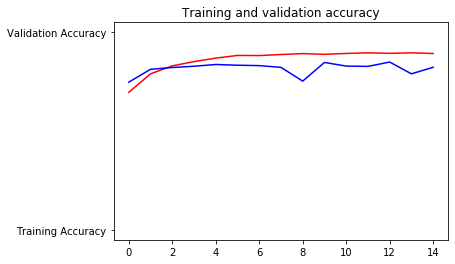

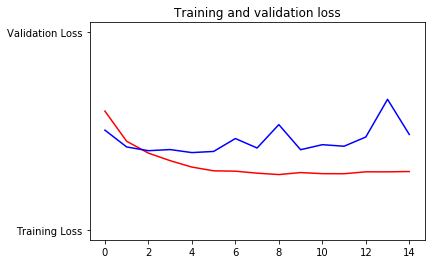

In [81]:
# PLOT LOSS AND ACCURACY
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')

# Desired output. Charts with training and validation metrics. No crash :)

In [84]:
# Here's a codeblock just for fun. You should be able to upload an image here 
# and have it classified without crashing

import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150,150, 3))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")

Using TensorFlow backend.


Saving cat-dog-1800x1200_cats_and_excessive_meowing_ref_guide.jpg to cat-dog-1800x1200_cats_and_excessive_meowing_ref_guide.jpg
Saving cat-dog-WALN4MAIT4I6VLRIPUMJQAJIME.jpg to cat-dog-WALN4MAIT4I6VLRIPUMJQAJIME.jpg
Saving cat-goosethecat-blogroll-1551733410083-1280w-1551990377836_1280w.jpg to cat-goosethecat-blogroll-1551733410083-1280w-1551990377836_1280w.jpg
Saving cat-Layer-1704-1920x840.jpg to cat-Layer-1704-1920x840.jpg
[1.]
cat-dog-1800x1200_cats_and_excessive_meowing_ref_guide.jpg is a dog
[1.]
cat-dog-WALN4MAIT4I6VLRIPUMJQAJIME.jpg is a dog
[1.]
cat-goosethecat-blogroll-1551733410083-1280w-1551990377836_1280w.jpg is a dog
[0.]
cat-Layer-1704-1920x840.jpg is a cat
